# Purchase Card Transactions - Anomaly Detection 
[Daniel Beltrán](https://www.linkedin.com/in/danielbeltranpardo/) - Apr 2021


Birmingham City Council is the local government body responsible for the governance of the City of Birmingham in England. For them, transparency is one of the main values they want to reflect, and with open data initiatives, they give access to be freely used, reused, and redistributed by anyone. That's why they started publishing all corporate purchases of card transactions since Apr 2014 until date,  our main goal will be to audit through an unsupervised machine learning algorithm if there is any anomaly present in the information that is exposed. 

Anomaly detection is an important tool for detecting fraud, network intrusion, or rare events that may have an impact but are hard to identify. In this notebook, we will use anomaly detection to finding patterns in data that don’t conform to a model of normal behavior for the corporate purchase of a card (if any). 

We will use the Framework of Microsoft Team Data Science Process (TDSP) and the Data science steps for ML by Google to determine the lifecycle outlines the major stages of this project, this will be: 
- Business Understanding
     - Define a problem
- Data Acquisition and Understanding
    - Data extraction
    - Data analysis
    - Data preparation
- Modeling
    - Model training
    - Model evaluation
- Deployment

This notebook will focus on the first three items and give some recommendations for the last item. 

In [1]:
# Importing Required Libraries 

# Web-Scrapping
from bs4 import BeautifulSoup
import urllib
import requests
import os 
from datetime import datetime, timedelta, date

# Data Analysis 
import pandas as pd
import numpy as np

# Visualization
import missingno as msno
import plotly.offline as py
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Model
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

#Config
pd.pandas.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import plotly.io as pio
pio.renderers.default = 'iframe'

## Business Understanding
As we mentioned earlier our main objective would be to identify anomalies in the transactions that occurred with the corporate purchase of a card for the Birmingham City Council, since we're making an internal audit of Birmingham City Council and see that they aren't misusing the credit card for odd purposes. The process if we anything abnormal is to mail:  foi.mailbox@birmingham.gov.uk asking for additional information related to a set of particular transactions or ask an accountant if the abnormality is due to a specific process (like chargeback). 

## Data Acquisition and Understanding
### Data Extraction
They gave us access to the [this url](https://data.birmingham.gov.uk/dataset/purchase-card-transactions) here we will find all the datasets from Apr 2014 to Jan 2018, we can then web scrap the page to obtain the distinct links and afterward download all the related dataset, we could do it manually but it would take time each time we want to access the data, it will be harder to replicate our experiment and we would incur into a risk of downloading the information twice or skip a file. Each of the files we identify within the webpage we will then save it to our local (in case the later they change anything within their webpage or they restrict the access through web scrappers) and finally we will read each file and concatenate in a complete dataset before we start our data analysis.

In [2]:
url = 'https://data.birmingham.gov.uk/dataset/purchase-card-transactions'

def get_beutiful_content(url):
    """
    Access the url that is inputted and get back a BeutifulSoup content (html prettify)
    
    Parameters
    ----------
    url : str
        Url as an string

    Returns
    -------
    BeautifulSoup content
    """
    
    url_request = requests.get(url)
    assert url_request.status_code == 200
    src = BeautifulSoup(url_request.content)
    return src

src = get_beutiful_content(url)
all_list = src.find_all('a', "resource-url-analytics")
all_xls = [tag['href'] for tag in all_list if tag['href'].find('.xls') != -1 or tag['href'].find('.csv') != -1]
print(all_xls[0],'\n',all_xls[-1])

https://data.birmingham.gov.uk/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/b4a15ade-11b1-4c98-88a0-8cd8408212ac/download/purchasecardtransactionsapril2014.xls 
 https://data.birmingham.gov.uk/dataset/cf552d08-cee9-43bf-8c0f-3196a9311799/resource/200906b7-366c-441c-9071-ec9ab086e193/download/cusersfinainmndesktoppublish-spend-january-2018.xls


In [3]:
dates = ["2014-04-01", "2018-01-30"]

def create_month_year_list(dates):
    """
    Creates a %Y-%m list for each month between a list of dates
    
    Parameters
    ----------
    dates : list
        List of dates the first would be the oldest and the second would be the newer 

    Returns
    -------
    mlist: List
        A list of all the dates between the input of the list of two dates 
    """
    
    start, end = [datetime.strptime(date, "%Y-%m-%d") for date in dates]
    mlist = []
    total_months = lambda dt: dt.month + 12 * dt.year
    for tot_m in range(total_months(start)-1, total_months(end)):
        y, m = divmod(tot_m, 12)
        mlist.append(datetime(y, m+1, 1).strftime("%Y-%m"))
    return mlist

names_xls = create_month_year_list(dates)
names_xls.remove('2015-04') # this month is missing
assert len(names_xls) == len(all_xls)

In [4]:
path_to_save = "./data/"

def save_all_files_local(all_xls, path):
    """
    Save all files from a list of URL's to a path, if the path isn't created it will create the folder.
    
    Parameters
    ----------
    all_xls : list
        List all the url's which would be downloaded and save
        
    path : str
        Path in which the files will be stored as a string 

    Returns
    -------
    None
    """
    
    for i, url_xls in enumerate(all_xls):

        file_format = url_xls[url_xls.rfind('.'):]
        save_name = path + names_xls[i] + file_format
        
        if os.path.exists(path_to_save):
            pass
        else:
            os.mkdir(path_to_save)
        
        if os.path.exists(save_name):
            pass
        
        else:

            if file_format == '.csv':
                response = urllib.request.urlopen(url_xls)
                csv = response.read()
                with open(path + names_xls[i] + file_format, 'wb') as f:
                    f.write(csv)
            else:
                urllib.request.urlretrieve(url_xls, save_name)

save_all_files_local(all_xls, path_to_save)

In [5]:
def get_dataset(data_path='./data/'):
    """
    From a specific route read all the files that are xls or csv format and 
    append them in one dataframe
    
    Parameters
    ----------
    data_path : str
        The data path in which all the files are.
        
    Returns
    -------
    final_df : pd.DataFrame
        The dataframe containing all the files
    """
    final_df = pd.DataFrame()
    local_list_xls = os.listdir(data_path) 
    for file in local_list_xls:
        if file.endswith('xls'):
            temp_df = pd.read_excel(data_path + file)
        if file.endswith('csv'):
            temp_df = pd.read_csv(data_path + file, sep=',')
        final_df = pd.concat([final_df, temp_df], axis=0, sort=True)
    return final_df

In [52]:
df = get_dataset()

### Data Analysis
#### Dataset general information 

The first thing we want to do is answer:
* What is the shape of the dataset?
* How many columns (features) are?
* What are the type of features?


In [53]:
print(f'Data shape: {df.shape} \n')
print(f'Information of data columns:{df.info()} \n')

Data shape: (186060, 29) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186060 entries, 0 to 5639
Data columns (total 29 columns):
AGENT                 151 non-null object
APPLICANT             151 non-null object
Accepted              151 non-null object
BILLING CUR CODE      88696 non-null object
BILLING CUR CODE.1    4598 non-null object
BILLING GROSS AMT     54229 non-null float64
CARD NUMBER           185908 non-null object
Category              151 non-null object
DEV                   151 non-null object
Directorate           169311 non-null object
Directorate           2062 non-null object
Directorates          9839 non-null object
LOCATION              151 non-null object
MERCHANT NAME         185908 non-null object
ORIGINAL CUR          54229 non-null object
ORIGINAL GROSS AMT    185908 non-null float64
REFERENCE             151 non-null object
Received_Date         151 non-null object
TRANS CAC CODE 1      185804 non-null object
TRANS CAC CODE 2      185673 non-null ob

From this we can get the sense of the total data set, we got around 186K samples and a total of 29 columns most of them are categorical and a few numerical, and last but no least a DateTime column. Also, we can see that the data set has some missing values, we will explore in more detail these missing values and determined what to do with them.

###### Exploring missing values

We will explore all the columns that have missing values, we want a nice clean dataset by the end of the exploration we will set up all the data transformations within a function.

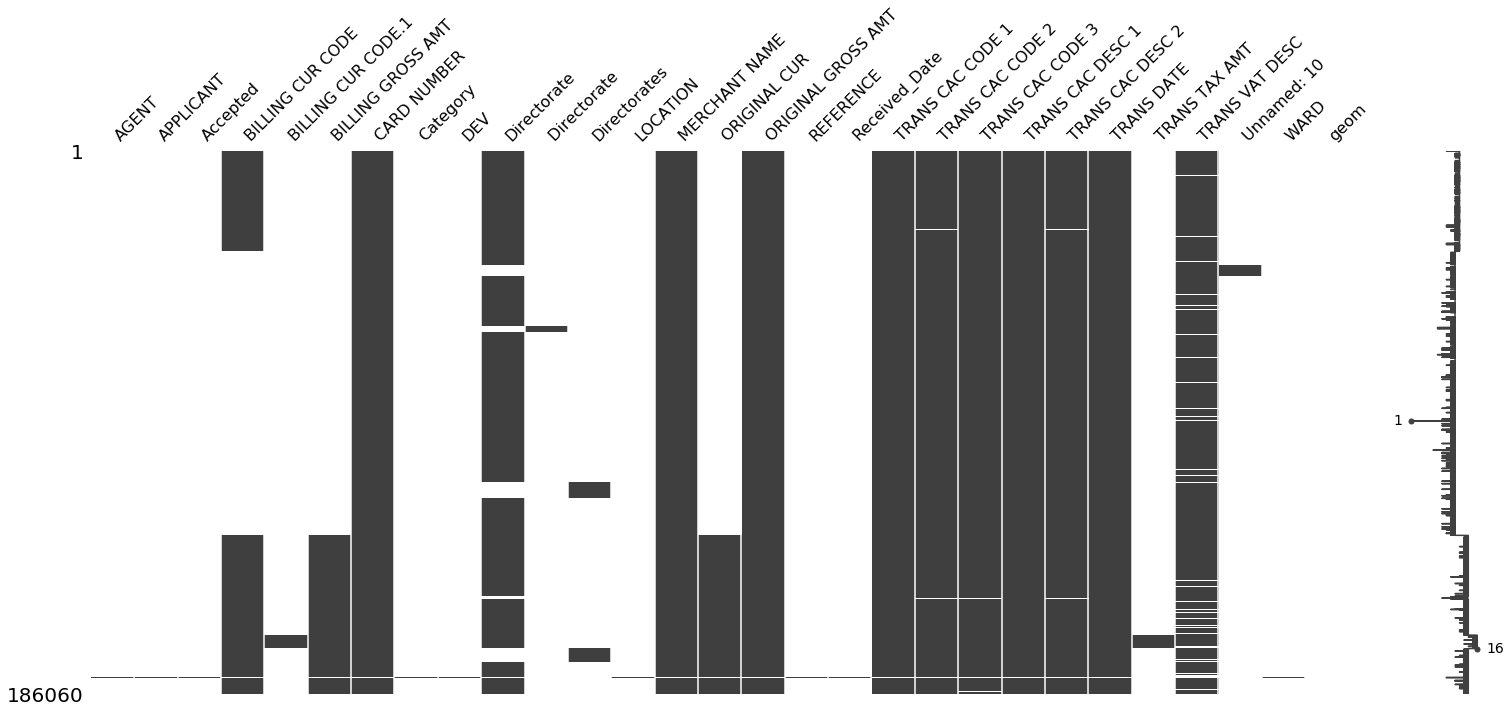

In [54]:
msno.matrix(df)

With the Missingno library, we can get a graphical sense of the missing values. Here we can see that some variables seem to transform only into 1, for example, all the combination of Directorate, Directorate (with space), Directorates, and Unnamed:10.

Also, we can see that there are variables that appear in all the datasets like the starting with TRANS_CAC, ORIGINAL GORSS AMT, MERCHANT NAME, CARD NUMBER, and others that don't seem to report the same information from other (maybe the CSV exception) like AGENT, WARD, GEOM. 

Let's then try to reduce to fewer columns for the features that are reported with a different name but are the same

In [55]:
df.sample(3)

,AGENT,APPLICANT,Accepted,BILLING CUR CODE,BILLING CUR CODE.1,BILLING GROSS AMT,CARD NUMBER,Category,DEV,Directorate,Directorate,Directorates,LOCATION,MERCHANT NAME,ORIGINAL CUR,ORIGINAL GROSS AMT,REFERENCE,Received_Date,TRANS CAC CODE 1,TRANS CAC CODE 2,TRANS CAC CODE 3,TRANS CAC DESC 1,TRANS CAC DESC 2,TRANS DATE,TRANS TAX AMT,TRANS VAT DESC,Unnamed: 10,WARD,geom
4049,NaN,NaN,NaN,NaN,NaN,NaN,************4244,NaN,NaN,Local Services,NaN,NaN,NaN,gloucestershire ga,NaN,3.20,NaN,NaN,L220,RUF0F,A00,Purchases Food,Illegal Money Lending T Stds Comm Inv.,2015-03-30,NaN,VR,NaN,NaN,NaN
2343,NaN,NaN,NaN,GBP,GBP,781.34,************6900,NaN,NaN,CYP&F SCHOOLS,NaN,NaN,NaN,klm uk,GBP,781.34,NaN,NaN,K260,REAJB,A00,Travel Foreign,Our Lady Of Lourdes RC Junior & Infant,2017-09-14,0.0,VZ,NaN,NaN,NaN
1607,NaN,NaN,NaN,NaN,NaN,NaN,************0812,NaN,NaN,CYP&F,NaN,NaN,NaN,amazon uk marketplace,NaN,8.99,NaN,NaN,L0J0,RV022,A00,Personal Needs,"Braymoor Rd Ch, 18, B33",2016-07-27,NaN,VZ,NaN,NaN,NaN


In [56]:
df[~df['APPLICANT'].isna()].sample(3)
df[(~df['AGENT'].isna()) &(~df['ORIGINAL GROSS AMT'].isna())]
df[~df['APPLICANT'].isna()].sample(3)
df[(~df['APPLICANT'].isna()) &(~df['ORIGINAL GROSS AMT'].isna())]

,AGENT,APPLICANT,Accepted,BILLING CUR CODE,BILLING CUR CODE.1,BILLING GROSS AMT,CARD NUMBER,Category,DEV,Directorate,Directorate,Directorates,LOCATION,MERCHANT NAME,ORIGINAL CUR,ORIGINAL GROSS AMT,REFERENCE,Received_Date,TRANS CAC CODE 1,TRANS CAC CODE 2,TRANS CAC CODE 3,TRANS CAC DESC 1,TRANS CAC DESC 2,TRANS DATE,TRANS TAX AMT,TRANS VAT DESC,Unnamed: 10,WARD,geom
112,"371512472, 90 Highgate Road, Walsall, WS1 3JA","Mr & Mrs Lance And Martha Gillett,85 Fitz Roy ...",15/01/2018,NaN,NaN,NaN,NaN,Householder,Erection of single storey forward and rear ext...,NaN,NaN,NaN,"85 Fitz Roy Avenue, Birmingham, B17 8RH",NaN,NaN,NaN,2018/00156/PA,10/01/2018,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,Quinton,NaN
68,"HG Design Limited, Sutton House, 4 Coles Lane,...","Mr Paul Zacavoli,18 Honeyborne Road, Sutton Co...",11/01/2018,NaN,NaN,NaN,NaN,Minor Dwellings,Erection of replacement dwellinghouse,NaN,NaN,NaN,"18 Honeyborne Road, Sutton Coldfield, Birmingh...",NaN,NaN,NaN,2017/10578/PA,12/12/2017,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,Sutton Trinity,NaN
111,"M Tufail, 269 Somerville Road, Small Heath, Bi...","Al Burhan Grammar School,Al-Burhan Grammar Sch...",16/01/2018,NaN,NaN,NaN,NaN,Minor Other,Erection of single storey side and front exten...,NaN,NaN,NaN,"Al-Burhan Grammar School, 258 Spring Road, Spr...",NaN,NaN,NaN,2018/00246/PA,12/01/2018,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,Acocks Green,NaN


,AGENT,APPLICANT,Accepted,BILLING CUR CODE,BILLING CUR CODE.1,BILLING GROSS AMT,CARD NUMBER,Category,DEV,Directorate,Directorate,Directorates,LOCATION,MERCHANT NAME,ORIGINAL CUR,ORIGINAL GROSS AMT,REFERENCE,Received_Date,TRANS CAC CODE 1,TRANS CAC CODE 2,TRANS CAC CODE 3,TRANS CAC DESC 1,TRANS CAC DESC 2,TRANS DATE,TRANS TAX AMT,TRANS VAT DESC,Unnamed: 10,WARD,geom


,AGENT,APPLICANT,Accepted,BILLING CUR CODE,BILLING CUR CODE.1,BILLING GROSS AMT,CARD NUMBER,Category,DEV,Directorate,Directorate,Directorates,LOCATION,MERCHANT NAME,ORIGINAL CUR,ORIGINAL GROSS AMT,REFERENCE,Received_Date,TRANS CAC CODE 1,TRANS CAC CODE 2,TRANS CAC CODE 3,TRANS CAC DESC 1,TRANS CAC DESC 2,TRANS DATE,TRANS TAX AMT,TRANS VAT DESC,Unnamed: 10,WARD,geom
61,"Gurmukhi Building Design Ltd, The Old School H...","Mrs F Missani,c/o agent",10/01/2018,NaN,NaN,NaN,NaN,Minor Dwellings,Outline application to determine the principle...,NaN,NaN,NaN,"Land Comprising, 51-55 College Road, Perry Barr",NaN,NaN,NaN,2017/10829/PA,19/12/2017,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,Oscott,NaN
121,"BDS Surveyors, 24 Boon Hill Road, Bignall End,...","Mr Abdul Aziz,164 Kenelm Road, Bordesley Green...",10/01/2018,NaN,NaN,NaN,NaN,Householder,Installation of step lift to front,NaN,NaN,NaN,"164 Kenelm Road, Bordesley Green, Birmingham, ...",NaN,NaN,NaN,2018/00202/PA,10/01/2018,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,Bordesley Green,NaN
76,"Umer Surveys, 469B Coventry Road, Small Heath,...","Mrs Rafana Shaheen,30 Castleford Road, Sparkhi...",17/01/2018,NaN,NaN,NaN,NaN,Householder,Erection of two and single storey side extension,NaN,NaN,NaN,"1 Dryden Grove, Acocks Green, Birmingham, B27 7QW",NaN,NaN,NaN,2018/00327/PA,16/01/2018,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,Acocks Green,NaN


,AGENT,APPLICANT,Accepted,BILLING CUR CODE,BILLING CUR CODE.1,BILLING GROSS AMT,CARD NUMBER,Category,DEV,Directorate,Directorate,Directorates,LOCATION,MERCHANT NAME,ORIGINAL CUR,ORIGINAL GROSS AMT,REFERENCE,Received_Date,TRANS CAC CODE 1,TRANS CAC CODE 2,TRANS CAC CODE 3,TRANS CAC DESC 1,TRANS CAC DESC 2,TRANS DATE,TRANS TAX AMT,TRANS VAT DESC,Unnamed: 10,WARD,geom


In [57]:
df.notnull().sum()

AGENT                    151
APPLICANT                151
Accepted                 151
BILLING CUR CODE       88696
BILLING CUR CODE.1      4598
BILLING GROSS AMT      54229
CARD NUMBER           185908
Category                 151
DEV                      151
Directorate           169311
Directorate             2062
Directorates            9839
LOCATION                 151
MERCHANT NAME         185908
ORIGINAL CUR           54229
ORIGINAL GROSS AMT    185908
REFERENCE                151
Received_Date            151
TRANS CAC CODE 1      185804
TRANS CAC CODE 2      185673
TRANS CAC CODE 3      185616
TRANS CAC DESC 1      185804
TRANS CAC DESC 2      185673
TRANS DATE            185908
TRANS TAX AMT           4598
TRANS VAT DESC        176065
Unnamed: 10             3959
WARD                     151
geom                       0
dtype: int64

It appears that there was a file that reported another format with some specific information, hence we will drop 151 records from this file. 

In [58]:
df[~df['Directorate'].isna()]['Directorate'].sample(3)
df[~df['Directorate '].isna()]['Directorate '].sample(3)
df[~df['Directorates'].isna()]['Directorates'].sample(3)
df[~df['Unnamed: 10'].isna()]['Unnamed: 10'].sample(3)

2111          CYP&F SCHOOLS
302     Corporate Resources
1913          CYP&F SCHOOLS
Name: Directorate, dtype: object

532                   CYP&F
366     Corporate Resources
1835         Local Services
Name: Directorate , dtype: object

3615    Local Services
692              CYP&F
1312             CYP&F
Name: Directorates, dtype: object

1032            CYP&F
2042    CYP&F SCHOOLS
2785    CYP&F SCHOOLS
Name: Unnamed: 10, dtype: object

As we assumed the Directorate, Directorate (with space), Directorates, and Unnamed:10 are all the same column, for that we will group them in just one column.

In [59]:
df[(df['BILLING CUR CODE']!=df['BILLING CUR CODE.1']) & (~df['BILLING CUR CODE.1'].isna())].shape

(0, 29)

Also the 'BILLING CUR CODE' and 'BILLING CUR CODE.1' appear to be the same, hence we will drop the 'BILLING CUR CODE.1' and leave only one

In [60]:
df[~(df['TRANS TAX AMT'].isna())].head(10)

,AGENT,APPLICANT,Accepted,BILLING CUR CODE,BILLING CUR CODE.1,BILLING GROSS AMT,CARD NUMBER,Category,DEV,Directorate,Directorate,Directorates,LOCATION,MERCHANT NAME,ORIGINAL CUR,ORIGINAL GROSS AMT,REFERENCE,Received_Date,TRANS CAC CODE 1,TRANS CAC CODE 2,TRANS CAC CODE 3,TRANS CAC DESC 1,TRANS CAC DESC 2,TRANS DATE,TRANS TAX AMT,TRANS VAT DESC,Unnamed: 10,WARD,geom
0,NaN,NaN,NaN,GBP,GBP,50.00,************5804,NaN,NaN,Adult & Communities,NaN,NaN,NaN,mrh six ways,GBP,50.00,NaN,NaN,K020,RVA12,A00,Vehicle Fuel,Enablement Tyburn Rd,2017-09-15,8.33,VR,NaN,NaN,NaN
1,NaN,NaN,NaN,GBP,GBP,60.01,************5804,NaN,NaN,Adult & Communities,NaN,NaN,NaN,beeches road servi,GBP,60.01,NaN,NaN,K020,RVA12,A00,Vehicle Fuel,Enablement Tyburn Rd,2017-09-22,10.00,VR,NaN,NaN,NaN
2,NaN,NaN,NaN,GBP,GBP,59.00,************2823,NaN,NaN,Adult & Communities,NaN,NaN,NaN,shell kings 587,GBP,59.00,NaN,NaN,K020,RV191,A00,Vehicle Fuel,Moseley Day Centre,2017-09-18,9.83,VR,NaN,NaN,NaN
3,NaN,NaN,NaN,GBP,GBP,59.72,************2823,NaN,NaN,Adult & Communities,NaN,NaN,NaN,shell kings 587,GBP,59.72,NaN,NaN,K020,RV191,A00,Vehicle Fuel,Moseley Day Centre,2017-09-29,9.95,VR,NaN,NaN,NaN
4,NaN,NaN,NaN,GBP,GBP,67.06,************7214,NaN,NaN,Adult & Communities,NaN,NaN,NaN,texaco ash motor,GBP,67.06,NaN,NaN,K020,RV12T,A00,Vehicle Fuel,"Shakti Elders Dce, 73 Conybere St, B12",2017-09-08,11.18,VR,NaN,NaN,NaN
5,NaN,NaN,NaN,GBP,GBP,61.33,************7214,NaN,NaN,Adult & Communities,NaN,NaN,NaN,texaco ash motor,GBP,61.33,NaN,NaN,K020,RV12T,A00,Vehicle Fuel,"Shakti Elders Dce, 73 Conybere St, B12",2017-09-13,10.22,VR,NaN,NaN,NaN
6,NaN,NaN,NaN,GBP,GBP,57.14,************7214,NaN,NaN,Adult & Communities,NaN,NaN,NaN,texaco ash motor,GBP,57.14,NaN,NaN,K020,RV12T,A00,Vehicle Fuel,"Shakti Elders Dce, 73 Conybere St, B12",2017-09-20,9.52,VR,NaN,NaN,NaN
7,NaN,NaN,NaN,GBP,GBP,66.01,************7214,NaN,NaN,Adult & Communities,NaN,NaN,NaN,texaco ash motor,GBP,66.01,NaN,NaN,K020,RV12T,A00,Vehicle Fuel,"Shakti Elders Dce, 73 Conybere St, B12",2017-09-27,11.00,VR,NaN,NaN,NaN
8,NaN,NaN,NaN,GBP,GBP,75.00,************8998,NaN,NaN,Adult & Communities,NaN,NaN,NaN,hmcourts-service.g,GBP,75.00,NaN,NaN,MC70,RV3T0,A00,Supplies & Sev Mic,Mental Health Management Budget,2017-09-05,0.00,VZ,NaN,NaN,NaN
9,NaN,NaN,NaN,GBP,GBP,75.00,************8998,NaN,NaN,Adult & Communities,NaN,NaN,NaN,hmcourts-service.g,GBP,75.00,NaN,NaN,MC70,RV3T0,A00,Supplies & Sev Mic,Mental Health Management Budget,2017-09-08,0.00,VZ,NaN,NaN,NaN


Original shape: (186060, 29)
Modified shape: (185909, 14)


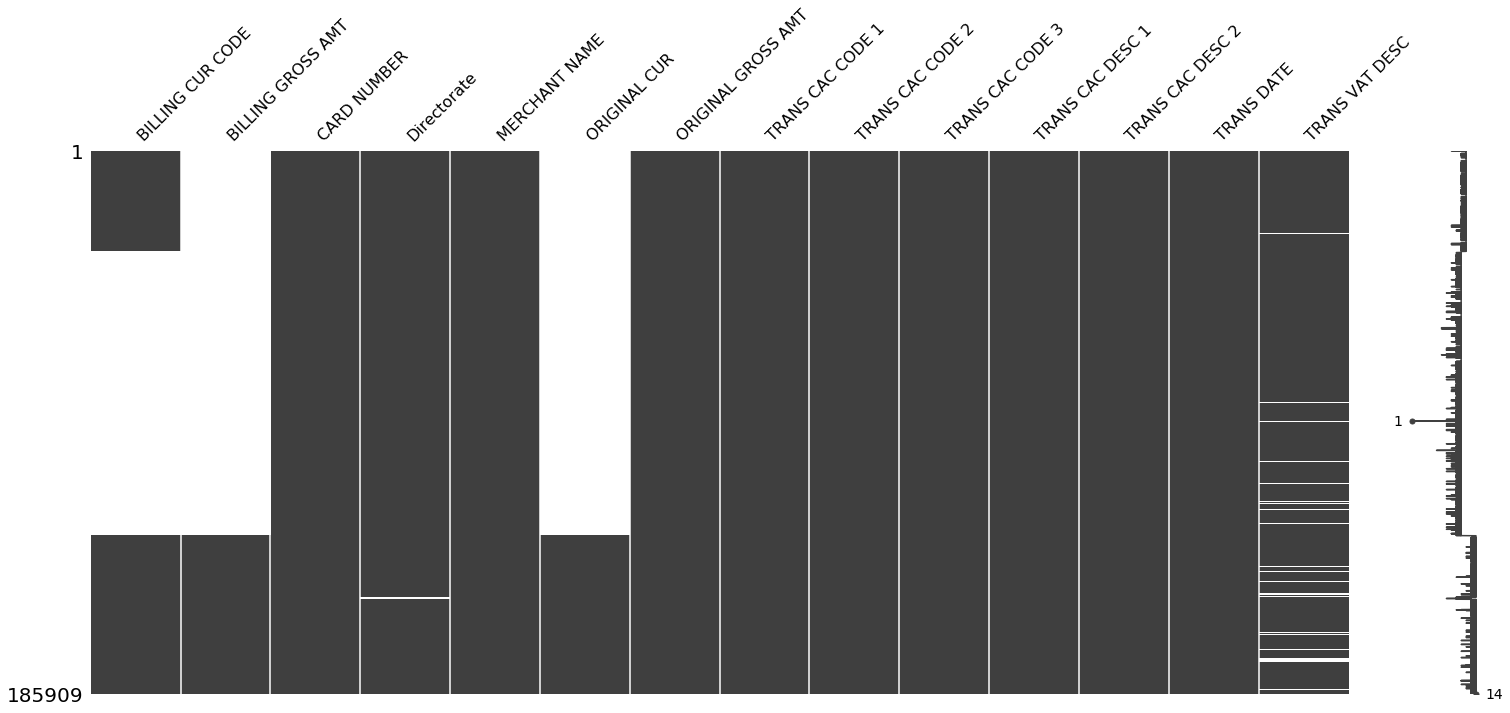

In [15]:
cols_to_drop = ['AGENT',
                 'APPLICANT',
                 'Accepted',
                 'Category',
                 'DEV',
                 'LOCATION',
                 'REFERENCE',
                 'Received_Date',
                 'WARD',
                 'geom', 
                 'Directorate ',
                 'Directorates',
                 'Unnamed: 10',
                 'BILLING CUR CODE.1',
                'TRANS TAX AMT']


def drop_and_group(df, cols_to_drop):
    """
    From the specified dataframe fill the directorates column with the information from the other similar columsn
    and drop all the columns specified as an argument. 
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to transform
    
    cols_to_drop : list
        The list of columns to be dropped after input the Directorate
        
    Returns
    -------
    df : pd.DataFrame
        The dataframe with all the transformations
    """
    print(f'Original shape: {df.shape}')
    df['Directorate'] = df['Directorate'].fillna(df['Directorate '])
    df['Directorate'] = df['Directorate'].fillna(df['Directorates'])
    df['Directorate'] = df['Directorate'].fillna(df['Unnamed: 10'])
    df = df.drop(columns = cols_to_drop)
    df = df.dropna(how='all')
    print(f'Modified shape: {df.shape}')
    return df 


df = drop_and_group(df, cols_to_drop)
msno.matrix(df)

As we can see we dealt with almost all the null we did not drop the original Cur, billing cur code since we need to explore first the data, determine the date and it could be that we just pick the segment in which those columns got data available. 
We will now explore each column from our dataset and get some insights into what we got in each column

#### Univariate exploration
What we want with this piece of code is to answer the following questions about the data: 
* How many unique values are per column?
* Is there any column in which duplicates don't make sense?
* How is the central tendency (mean, median, mode) for each numerical variable?
* What are the labels (frequency of each category) composition for each categorical variable? 

In [16]:
df.nunique()

BILLING CUR CODE          1
BILLING GROSS AMT     18904
CARD NUMBER            1523
Directorate              18
MERCHANT NAME         15856
ORIGINAL CUR             19
ORIGINAL GROSS AMT    32612
TRANS CAC CODE 1        143
TRANS CAC CODE 2       1397
TRANS CAC CODE 3         28
TRANS CAC DESC 1        143
TRANS CAC DESC 2       1382
TRANS DATE             1332
TRANS VAT DESC            7
dtype: int64

As we can see from the BILLING CUR CODE just got 1 value, that being said it doesn't add any valuable information. From the rest of variables, we got multiple categories which could be worrisome if we want to train an Unsupervised Learning Algorithm 

### Categorical Analysis

In [17]:
df_cat = df.select_dtypes(include='O')

def categorical_report(df):
    """
    Creates a categorical report with the total categories and percentag from each
    for all the columns from the dataframe input. 
    
    Parameters
    ----------
    df : pd.DataFrame
        The dataframe which will be reported

    Returns
    -------
    None
    """
    for col in df:
        temp = df_cat[col].value_counts(normalize=True)
        temp = temp.reset_index()
        temp['cumsum'] = temp[col].cumsum()
        col_til = temp[temp['cumsum'] > 0.8].iloc[0,:].name+1
        print(f'Total categories in {col}: {df[col].value_counts(normalize=True).shape[0]}')
        print(f'80% reached until {col_til} categories')
        print(df[col].value_counts(normalize=True).apply('{0:.3f}'.format), '\n')
        
categorical_report(df_cat)

Total categories in BILLING CUR CODE: 1
80% reached until 1 categories
GBP    1.000
Name: BILLING CUR CODE, dtype: object 

Total categories in CARD NUMBER: 1523
80% reached until 488 categories
************6308    0.014
************6720    0.012
************6316    0.012
************7710    0.010
************6387    0.007
************8192    0.007
************6034    0.007
************3929    0.006
************8053    0.006
************4035    0.006
************2968    0.005
************5412    0.005
************6740    0.005
************4243    0.005
************1436    0.005
************6158    0.005
************3443    0.004
************4471    0.004
************4244    0.004
************7962    0.004
************5037    0.004
************0276    0.004
************4428    0.004
************2700    0.004
************7784    0.004
************8998    0.004
************9215    0.004
************9391    0.003
************0047    0.003
************1226    0.003
                    ...  

From this report we can get an idea about the distribution of the different categories, there are columns with categories that are super granular and it wouldn't make sense to use them. 
Here are the main conclusions:
* CARD NUMBER won't be a feature we will use, there isn't a card that is used more than 1%
* Directorate presents some text issues, then isn't grouping correctly we will fix with some basic string treatment.
* Merchant name is super dispersed, we will try just to keep the first piece of the string until the first space trying to maybe group them and reducing the total categories.
* For the ORIGINAL CUR we will use GBP and group all into an Others category.
* We will IN TRANS CAC CODE 1 group all the categories that have less than 5% into others category. 
* We will drop the TRANS CAC CODE 2 column since it's more specific.
* We will use TRANS CAC CODE 3 A00 and group the rest into others categories.
* We will drop TRANS CAC DESC 1, TRANS CAC DESC 2 since they're redundant they're in fact the same TRANS CAC CODE [See in source](https://www.whatdotheyknow.com/request/139933/response/342958/attach/5/COST%20CENTRE%20LISTING.csv.txt?cookie_passthrough=1)
* We will in TRANS VAT DESC map from VL onwards to others category.

In [18]:
def categorize_other(serie, threshold):
    """
    Populate a serie with the 'Others' if the frecuency in percentage doesn't pass a threshold 
    
    Parameters
    ----------
    serie : pd.Series
        The serie to transform
    
    threshold : float
        The threshold of the percentage
        
    Returns
    -------
    
    serie: pd:Series
        The Series transformed
    """
    temp = serie.value_counts(normalize = True)
    temp = temp[temp > threshold].reset_index()['index'].to_dict()
    temp_dict = {v:v for v in temp.values()}
    serie = serie.map(temp_dict).fillna('Others')
    return serie

def categorical_changes(df):
    """
    Transform the current categorical standarizing the directorate column, getting the first token on the merchant name
    mapping with others category the 'ORIGINAL CUR', 'TRANS CAC CODE 1', 'TRANS CAC CODE 3' and 'TRANS VAT DESC'
    and dropping the rest of the categories
    
    Parameters
    ----------
    df : pd.Dataframe
        The dataframe to change
    
    Returns
    -------
    
    df : pd.Dataframe
        The dataframe transformed
        
    """
    
    threshold = 0.05

    directorate_map = {'cyo&f': 'cyp&f',
                  'adults & communities':'adult & communities',
                  'adults & comms':'adult & communities',}
    
    drop_cat_cols = ['BILLING CUR CODE','CARD NUMBER',
                     'TRANS CAC CODE 2','TRANS CAC DESC 1',
                     'TRANS CAC DESC 2']

                                      
    df['Directorate'] = df['Directorate'].apply(lambda x: str(x).lower().strip())
    df['Directorate'] = df['Directorate'].map(directorate_map).fillna(df['Directorate'])
    df['MERCHANT NAME'] = df['MERCHANT NAME'].apply(lambda x: str(x).split()[0])
    df['ORIGINAL CUR'] = df['ORIGINAL CUR'].apply(lambda x: np.where(x == 'GBP', 'GBP', 'Others'))
    df['TRANS CAC CODE 1'] = categorize_other(df['TRANS CAC CODE 1'], threshold)
    df['TRANS CAC CODE 3'] = categorize_other(df['TRANS CAC CODE 3'],threshold)
    df['TRANS VAT DESC'] = categorize_other(df['TRANS VAT DESC'],threshold)
    df = df.drop(columns = drop_cat_cols)
    return df 

df = categorical_changes(df)

In [19]:
df_cat = df.select_dtypes(include='O')
categorical_report(df_cat)

Total categories in Directorate: 11
80% reached until 3 categories
cyp&f schools                   0.473
local services                  0.228
cyp&f                           0.136
corporate resources             0.067
adult & communities             0.067
development                     0.022
nan                             0.004
adult social care and health    0.003
adults                          0.000
corporate procurement           0.000
                                0.000
Name: Directorate, dtype: object 

Total categories in MERCHANT NAME: 7994
80% reached until 259 categories
amazon                    0.184
travelodge                0.053
tesco                     0.049
asda                      0.036
paypal                    0.019
sainsburys                0.018
the                       0.017
shell                     0.015
bp                        0.015
argos                     0.014
post                      0.013
w                         0.012
esso                   

Merchant name got improved, however is still granular so it won't work for the anomaly detection, then we will also drop the column.

In [20]:
df = df.drop(columns=['MERCHANT NAME'])

### Numerical Analysis

In [21]:
df_numeric = df.select_dtypes(include = 'number')

In [22]:
df_numeric.describe()

,BILLING GROSS AMT,ORIGINAL GROSS AMT
count,54229.000000,185908.000000
mean,207.605785,176.607761
std,2369.229937,2133.811542
min,-486980.090000,-486980.090000
25%,13.180000,12.790000
50%,43.000000,40.480000
75%,108.000000,92.230000
max,44433.550000,280102.230000


It appear that the two columns are almost the same we will check if they're different only on the non-null part of BILLING GROSS AMT

In [23]:
temp = df[~df['BILLING GROSS AMT'].isna()]
temp[temp['BILLING GROSS AMT'] != temp['ORIGINAL GROSS AMT']].shape

(317, 8)

In [24]:
fig = px.violin(df, y="ORIGINAL GROSS AMT", box=True, # draw box plot inside the violin
                points='all', # can be 'outliers', or False
               )
fig.show()

There seem to be outliers on the negative side, maybe there are some chargebacks. For now we will leave them and the model should detect specially the big negative one.

In [25]:
df = df.drop(columns ='BILLING GROSS AMT')

### Datetime variables

We have so far analyzed all the information that we got from our data frame except for the DateTime column, that being said we could do a basic analysis.

In [26]:
df['TRANS DATE'].describe()

count                  185908
unique                   1332
top       2014-06-11 00:00:00
freq                      473
first     2013-11-12 00:00:00
last      2018-02-05 00:00:00
Name: TRANS DATE, dtype: object

In [27]:
df[df['TRANS DATE']<pd.Timestamp(year= 2014, month = 4, day = 1)]

,Directorate,ORIGINAL CUR,ORIGINAL GROSS AMT,TRANS CAC CODE 1,TRANS CAC CODE 3,TRANS DATE,TRANS VAT DESC
28,adult & communities,Others,-594.00,L100,A00,2013-11-12,VR
1679,cyp&f schools,Others,-10.54,L220,A00,2014-03-27,VZ
2316,local services,Others,98.33,K020,A00,2014-03-06,VR


As we can see we got some information related to some dates from 2013 but seem to be a chargeback that happened maybe in Apr (that's why it's negative), to help the model to detect those anomalies we will the year and month and the weekday because there can be a pattern and could indicate an anomaly if we buy something on weekends.

In [28]:
df['day'] = df['TRANS DATE'].dt.day_name()
df['year-month'] =  df['TRANS DATE'].apply(lambda x: str(x)[:7])

In [29]:
df['TRANS DATE'].dt.day_name().value_counts(normalize = True, dropna= False)

Wednesday    0.203239
Tuesday      0.200512
Thursday     0.190862
Monday       0.177108
Friday       0.164478
Saturday     0.036340
Sunday       0.027454
NaN          0.000005
Name: TRANS DATE, dtype: float64

In [30]:
df['year-month'].value_counts(normalize = True, dropna= False)

2014-06    0.045151
2017-11    0.030380
2017-05    0.028799
2016-11    0.028600
2016-09    0.028261
2016-06    0.027675
2015-11    0.027271
2017-07    0.027132
2016-07    0.026943
2017-06    0.026916
2018-01    0.026255
2017-01    0.025986
2014-07    0.025728
2014-11    0.025179
2016-02    0.025098
2015-06    0.024975
2015-01    0.024840
2016-01    0.024770
2015-03    0.024765
2017-03    0.024378
2016-05    0.024378
2015-09    0.023727
2017-09    0.023673
2017-10    0.023630
2016-10    0.023269
2015-10    0.022151
2015-07    0.021844
2014-09    0.021688
2016-03    0.021602
2014-10    0.021570
2017-02    0.021123
2015-02    0.021107
2016-04    0.020435
2014-12    0.019859
2015-05    0.019235
2015-12    0.019208
2016-12    0.017121
2017-04    0.016062
2016-08    0.014061
2014-04    0.013792
2017-08    0.013308
2014-08    0.011737
2015-08    0.010376
2018-02    0.004034
2015-04    0.001119
2014-05    0.000705
2017-12    0.000065
2014-03    0.000011
2013-11    0.000005
NaT        0.000005


From these two features we want:
* Identify if there is any group of transactions happening on the weekends.
* Months should be almost uniformly be distributed since normally there is a budget, if there is any month with fewer or more transactions than the regular it could be an anomaly.

In [31]:
df = df.drop(columns = 'TRANS DATE')

### Multivariate analysis

In [32]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="day")
fig.show()

From this graph we can group together the weekends and group the weeks since they got a similar behaviour it will help us also to reduce the dimensionality

In [33]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="year-month")
fig.show()

We will leave the months as we got them since they appear to be more expenses on the earlier years but there are values in each month that appear as outliers

In [34]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="Directorate")
fig.show()

There seem to be some outliers specially when the directorate was blank, also the corporate resources seem to display a particular behaviour compared to the others.

In [35]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="ORIGINAL CUR")
fig.show()

When the original currency was different from the GBP there they seem a bigger amount from the original gross amt.

In [36]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="TRANS CAC CODE 1")
fig.show()

MC70, L100 and the others appear to be categories heavy on outliers and different from the rest.

In [37]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="TRANS CAC CODE 3")
fig.show()

Both labels appear to have outliers specially on A00 label (which is the majority) 

In [38]:
fig = px.box(df, x="ORIGINAL GROSS AMT", y="TRANS VAT DESC")
fig.show()

Last, the others category is the one that doesn't contain large original gross amounts, and VZ and VR display a similar behavior however VR is the one displaying big negative outliers on the left and VZ on the right.

### Data preparation

We've used multiple things to prepare our data, now we will do the final step. With the intention to, later on, facilitate the process of transforming this experimental code into production code we will use just one function to preprocess the data frame before, we will use the previous functions we have used and made some slight changes to some after the conclusion of the analysis. 

Data preparation is a critical process that will facilitate our experimentation in case we want a future to try a new idea. 

In [39]:
df = get_dataset()

def categorical_changes(df):
    """
    Transform the current categorical standarizing the directorate column
    mapping with others category the 'ORIGINAL CUR', 'TRANS CAC CODE 1', 'TRANS CAC CODE 3' and 'TRANS VAT DESC'
    and dropping the rest of the categories
    
    Parameters
    ----------
    df : pd.Dataframe
        The dataframe to change
    
    Returns
    -------
    
    df : pd.Dataframe
        The dataframe transformed
        
    """
    threshold = 0.05

    directorate_map = {'cyo&f': 'cyp&f',
                  'adults & communities':'adult & communities',
                  'adults & comms':'adult & communities',}
    
    drop_cat_cols = ['BILLING CUR CODE','CARD NUMBER',
                     'TRANS CAC CODE 2','TRANS CAC DESC 1',
                     'TRANS CAC DESC 2', 'BILLING GROSS AMT',
                    'MERCHANT NAME']

                                      
    df['Directorate'] = df['Directorate'].apply(lambda x: str(x).lower().strip())
    df['Directorate'] = df['Directorate'].map(directorate_map).fillna(df['Directorate'])
    df['MERCHANT NAME'] = df['MERCHANT NAME'].apply(lambda x: str(x).split()[0])
    df['ORIGINAL CUR'] = df['ORIGINAL CUR'].apply(lambda x: np.where(x == 'GBP', 'GBP', 'Others'))
    df['TRANS CAC CODE 1'] = categorize_other(df['TRANS CAC CODE 1'], threshold)
    df['TRANS CAC CODE 3'] = categorize_other(df['TRANS CAC CODE 3'],threshold)
    df['TRANS VAT DESC'] = categorize_other(df['TRANS VAT DESC'],threshold)
    df = df.drop(columns = drop_cat_cols)
    return df 


def create_date_features(df):
    """
    Create the weekend and year-month features for the input dataframe 
    
    Parameters
    ----------
    df : pd.Dataframe
        The dataframe to in which new features will be inserted
    
    Returns
    -------
    
    df : pd.Dataframe
        The dataframe with the columns weekend and year-month 
        
    """
    weekday_map = {'Saturday': 1,
              'Sunday':1}

    df['weekend'] = df['TRANS DATE'].dt.day_name().map(weekday_map).fillna(0)
    df['year-month'] =  df['TRANS DATE'].apply(lambda x: str(x)[:7])
    df = df.drop(columns = 'TRANS DATE')
    return df


def prepare_data(df):
    """
    Preprocess the dataframe to be ready to be encoded
    
    Parameters
    ----------
    df : pd.Dataframe
        The original dataframe to be transformed
    
    Returns
    -------
    
    df : pd.Dataframe
        The dataframe after all transformations
        
    """
    df = drop_and_group(df, cols_to_drop)
    df = categorical_changes(df)
    df = create_date_features(df)
    print(f'Pre drop of nan: {df.shape}')
    df = df.dropna()
    print(f'End of transformation shape: {df.shape}')
    return df 

df = prepare_data(df)

Original shape: (186060, 29)
Modified shape: (185909, 14)
Pre drop of nan: (185909, 8)
End of transformation shape: (185908, 8)


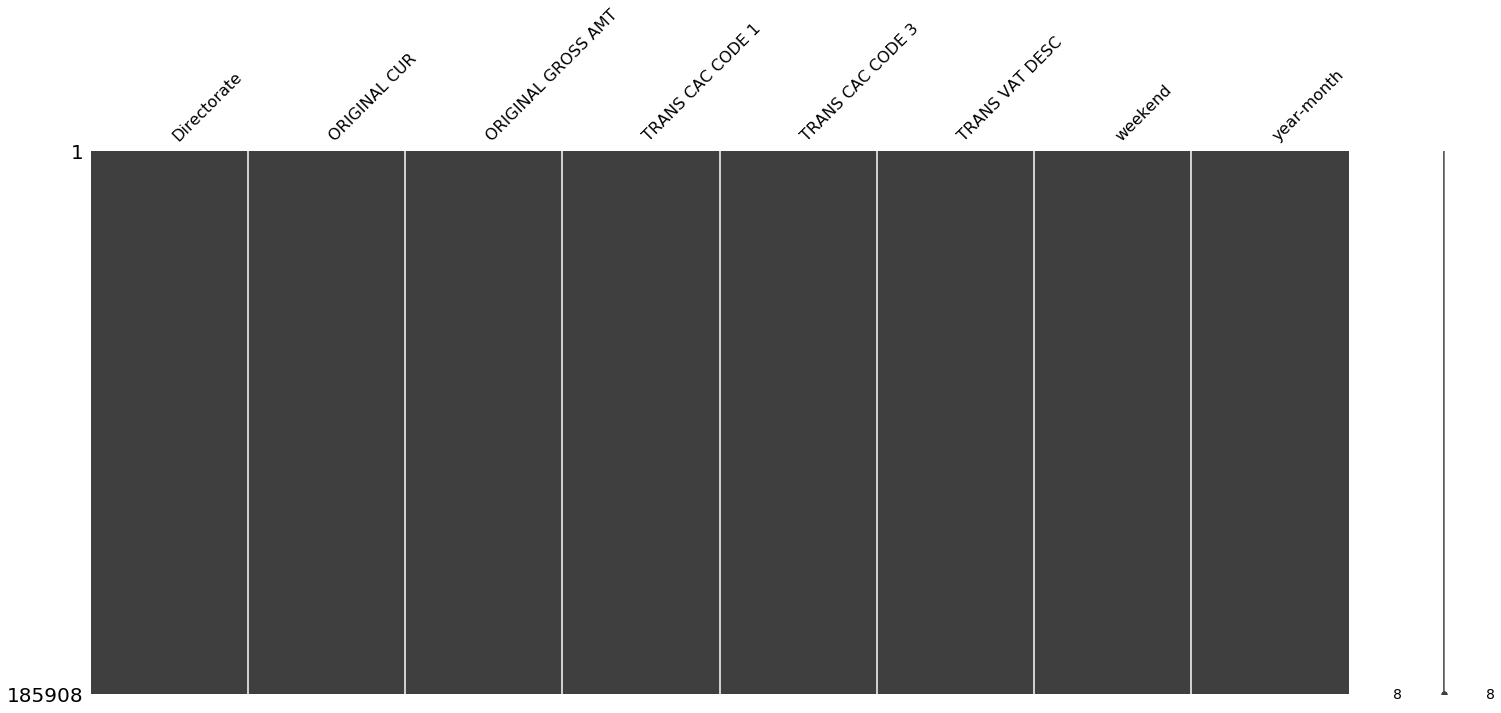

In [50]:
msno.matrix(df)

We did the same steps we just added the last drop NaN method for the columns that still contain NaN's for the BILLING GROSS AMT. If in later files there is a higher frequency on Null for this column we should ask why is this happening it could be an error when the information is being uploaded, also we could deal with it imputation using the median or mean or another metric. 
In this case, is just 1 case so we decided to drop.

Also we can see that we deal with all the 

## Modelling

In [40]:
def encode_df_train(df, anomaly_detector = None, pca = False, n_components=None):
    """
    Preprocess the dataframe to be ready to be encoded
    
    Parameters
    ----------
    df : pd.Dataframe
        The dataframe pre proccesed 
        
    anomaly_detector : Sklearn.model class
        The model which would be fitted 
    
    pca : bool
        If a PCA will be performed mark as true, default False
        
    n_components : float
        The number of components for the PCA, defaults None
        
    Returns
    -------
    
    combined_features : Sklearn.model class 
        The model with the dataframe fitted
        
    """
    
    ordinal_col = ['year-month']

    ohe_col = ['Directorate', 'ORIGINAL CUR','TRANS CAC CODE 1',
               'TRANS CAC CODE 3', 'TRANS VAT DESC', 'weekend']

    numeric_col = ['ORIGINAL GROSS AMT']
    
    ordinal_transformer = Pipeline(steps=[('ord_encode', OrdinalEncoder())])
    ohe_transformer = Pipeline(steps=[('ohe_encode', OneHotEncoder(sparse = False))])
    scaler_transform = Pipeline(steps=[('scaler', StandardScaler())])
    
    transformer = ColumnTransformer(transformers=[('ord', ordinal_transformer, ordinal_col),
                                                 ('num', scaler_transform, numeric_col),
                                                 ('ohe', ohe_transformer, ohe_col)])
      
    if pca:
        combined_features = Pipeline(steps=[('preprocessor', transformer),
                                       ('pca', PCA(n_components = n_components))])
        combined_features.fit(df)
        
    else:
        combined_features = Pipeline(steps=[('preprocessor', transformer),
                                       ('anomaly_det', anomaly_detector)])
        combined_features.fit(df)
    
    return combined_features

In the previous lines of code we accomplished encode the variable like the following:
* For the 'year-month' column that we previously created have a natural order according to months, that being said we will use the ordinal transformer also to avoid creating more columns (compared to an OneHotEncode).
* For the 'Directorate', 'ORIGINAL CUR','TRANS CAC CODE 1','TRANS CAC CODE 3', 'TRANS VAT DESC', and 'weekend' we used the one-hot encoding. This because there isn't a natural order and we want to include as much information as possible. 
* For the 'ORIGINAL GROSS AMT we scale the data by removing the mean and scaling to unit variance.

For the models, we will try three outlier detection algorithms an Isolation Forest, Local Outlier Factor, and One-Class SVM. These three algorithms help us to separate a core of regular observations from some polluting ones which are our main business objective.

In [41]:
isolation_forest = encode_df_train(df, IsolationForest(behaviour="new", contamination='auto'))
local_outlier_f = encode_df_train(df, LocalOutlierFactor(novelty=True, contamination='auto'))
one_class_svm = encode_df_train(df, OneClassSVM(nu=0.1, kernel="rbf", gamma='auto'))

In [42]:
result_svm = one_class_svm.predict(df)
result_isolation = isolation_forest.predict(df)
result_local = local_outlier_f.predict(df)
result_local = np.where(result_local == 1, -1, 1)

Right now we hold if a point was or wasn't an anomaly according to each classifier, it's hard to meassure an unsupervised algorithm without: an expert on the subject reviewing a sample or idially have label would tell whether the transaction is abnormal or not. However, we can graphically see if they're making any sense that's why we introduced a PCA, PCA will help us to reduce the dimensions of our data set maximizing the variance and ideally we can explain with 2 or 3 components most of our dataset.

In [44]:
pca = encode_df_train(df, pca=True)
with np.printoptions(precision=4, suppress=True):
    print(pca.named_steps['pca'].explained_variance_ratio_)

[0.9809 0.0058 0.0035 0.0018 0.0014 0.001  0.0009 0.0008 0.0007 0.0007
 0.0006 0.0005 0.0004 0.0003 0.0002 0.0001 0.0001 0.0001 0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.    ]


We noticed that the majority of the variance can be explained with one component, the second one will help us to visualized now we train for two components and add the results of each classifier to graph them and see how are the results looking.

In [45]:
pca = encode_df_train(df, pca=True, n_components = 2)
principalDf = pd.DataFrame(data = pca.transform(df)
             , columns = ['PC1', 'PC2'])

principalDf['Local_Out'] = result_local
principalDf['Isolation'] = result_isolation
principalDf['SVM'] = result_svm

In [46]:
def plot_PCA(df_pca, target_col):
    """
    Plot the 2 dimension PCA with a target column
    
    Parameters
    ----------
    df_pca : pd.Dataframe
        The dataframe which contains a 2 Dimension PCA
        
    target_col : str
        The name of the column that would be compared in the pca
           
    Returns
    -------
    
    None
        
    """
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA ' + target_col, fontsize = 20)

    targets = [-1,1]
    colors = ['r', 'b']
    markers = ['x','o']
    for target, color, marker in zip(targets,colors,markers):
        indicesToKeep = df_pca[target_col] == target
        ax.scatter(df_pca.loc[indicesToKeep, 'PC1']
                   , df_pca.loc[indicesToKeep, 'PC2']
                   , c = color
                   , s = 14
                   , marker=marker)
    ax.legend(targets)
    ax.grid()

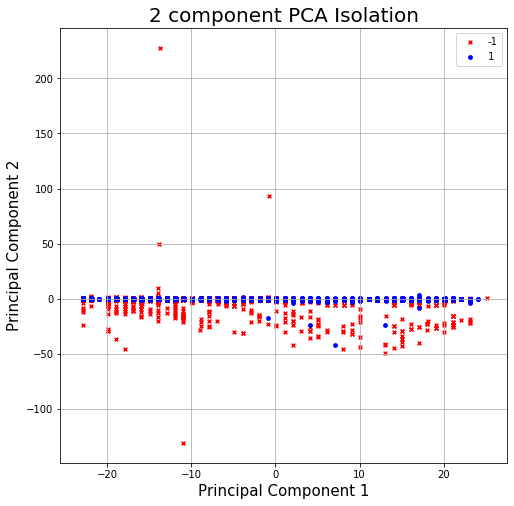

In [47]:
plot_PCA(principalDf, 'Isolation')

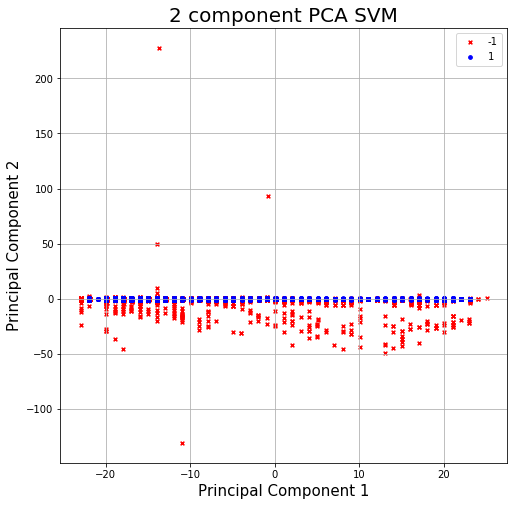

In [48]:
plot_PCA(principalDf, 'SVM')

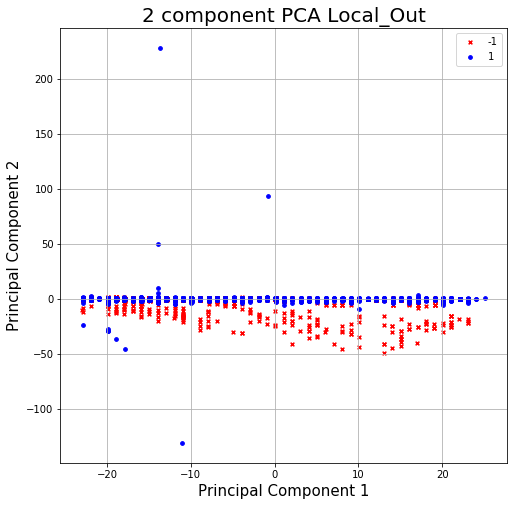

In [49]:
plot_PCA(principalDf, 'Local_Out')

What we can conclude from our results is that the algorithms appear to be classified correctly, everything that is on the X-axis and is close to 0 is a normal transaction and everything that gets far from that axis seem to be an anomaly. Please note that our anomaly is more sensitive on Y-Axis than on X-Axis. 

The SVM appears to be the one that got clean predictions, however, SVM is known to be sensitive to outlier and require requires fine-tuning of its hyperparameter $nu$ to handle outliers and prevent overfitting also the algorithm is O(N^2) and if the dataset gets bigger it's recommended to use the Isolation Forest.

The Local Outlier seems graphical to not do correctly the classification, this is since it uses underlying it's using a k-NN algorithm.

At last, the algorithm that seems to perform the best, being the best that graphically you can see the outliers and make sense and computationally efficient is the Isolation Forest.

## Next Steps

We would be missing the deployment components, however, before start coding anything on this side we would need to understand according to the business requirements if predictions would be made in real-time or on a batch basis.

Afterward, to see our model into production we would need to refine the technical part like: code review, unitary test, integration test, API exposure, dockerize, and more but more importantly we would need the abnormal transaction that we already identified. 

Also, we could start again our data science process with a different scope, for example, an anomaly detector on a credit card level, try to discover the profiles of the users that are using each credit card (if any), try to guess future transactional behaviors for the financial team in the Birmingham City Council and correctly make the different budgets but as always the starting point and critical is to understand what problem are we trying to solve.